In [13]:
import os, shutil, pathlib

original_dir = pathlib.Path("data")
new_base_dir = pathlib.Path("subset")

In [14]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=1, end_index=100)
make_subset("validation", start_index=100, end_index=150)
make_subset("test", start_index=150, end_index=250)

In [15]:
import keras

conv_base = keras.models.load_model("base.keras")

ValueError: Layer 'block1_conv1' expected 2 variables, but received 0 variables during loading. Expected: ['block1_conv1/kernel:0', 'block1_conv1/bias:0']

In [4]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.src.applications import imagenet_utils

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = imagenet_utils.preprocess_input(
            images, mode="caffe"
        )
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

Found 1998 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
1/1 [==============================] - 1s 897ms/step


In [5]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.checkpoint",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 4.0671 - accuracy: 0.9720INFO:tensorflow:Assets written to: feature_extraction.checkpoint\assets


INFO:tensorflow:Assets written to: feature_extraction.checkpoint\assets


63/63 [==============================] - 4s 69ms/step - loss: 4.0671 - accuracy: 0.9720 - val_loss: 5.3005 - val_accuracy: 0.9690
Epoch 2/20
62/63 [============================>.] - ETA: 0s - loss: 1.7886 - accuracy: 0.9829INFO:tensorflow:Assets written to: feature_extraction.checkpoint\assets


INFO:tensorflow:Assets written to: feature_extraction.checkpoint\assets


63/63 [==============================] - 4s 57ms/step - loss: 1.7761 - accuracy: 0.9830 - val_loss: 2.5594 - val_accuracy: 0.9760
Epoch 3/20
63/63 [==============================] - 3s 50ms/step - loss: 1.2736 - accuracy: 0.9900 - val_loss: 2.9124 - val_accuracy: 0.9780
Epoch 4/20
63/63 [==============================] - 3s 44ms/step - loss: 0.3874 - accuracy: 0.9955 - val_loss: 4.8321 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 3s 43ms/step - loss: 0.9680 - accuracy: 0.9955 - val_loss: 5.7310 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6875 - accuracy: 0.9925 - val_loss: 2.5669 - val_accuracy: 0.9790
Epoch 7/20
63/63 [==============================] - 2s 39ms/step - loss: 0.2646 - accuracy: 0.9970 - val_loss: 3.4968 - val_accuracy: 0.9780
Epoch 8/20
63/63 [==============================] - 2s 36ms/step - loss: 0.4654 - accuracy: 0.9955 - val_loss: 4.6968 - val_accuracy: 0.9690
Epoch 9/20
63/63 [======

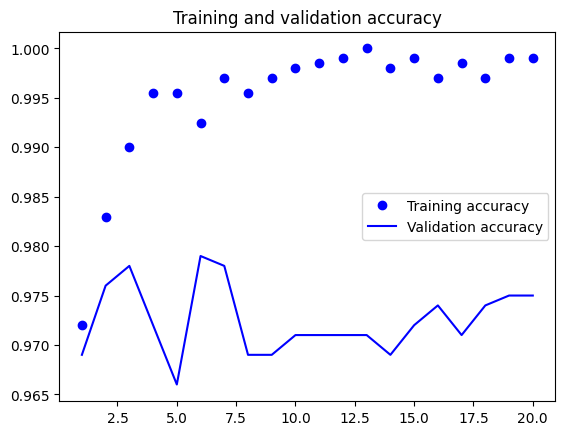

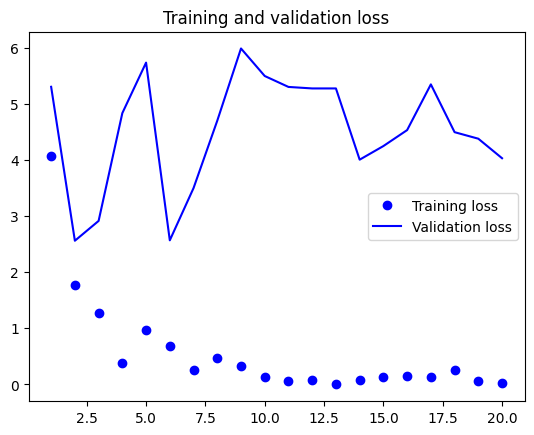

In [8]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_model = keras.models.load_model("feature_extraction.checkpoint")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 5ms/step - loss: 4.5521 - accuracy: 0.9755
Test accuracy: 0.975


In [25]:
model.save("feature_extraction.keras")